In [1]:
import os
import sys
import json
sys.path.append("/home/vassm/entity_alignment/kg_entity_alignment_2024/notebooks/data_prep")

In [ ]:
from loaders import graph_folder_path, gold_folder_path, load_gold
from sentence_transformers import util, SentenceTransformer
import torch

In [3]:
dogtags_output_path = "/home/vassm/entity_alignment/kg_entity_alignment_2024/features/dogtags/version2"
embeddings_output_path = "/home/vassm/entity_alignment/kg_entity_alignment_2024/features/embeddings/version2"

In [4]:
os.listdir(gold_folder_path)

['marvelcinematicuniverse-marvel.xml',
 'memoryalpha-memorybeta.xml',
 'memoryalpha-stexpanded.xml',
 'starwars-swg.xml',
 'starwars-swtor.xml']

In [5]:

gold_files = os.listdir(gold_folder_path)
summa = 0
for pair in gold_files:
    loaded_gold = load_gold(pair)
    print(len(loaded_gold[0]))
    summa += len(loaded_gold[0])
print(summa)

1667
9365
1779
1121
1429
15361


In [6]:
found_golds_on_position = dict()

gold_files = os.listdir(gold_folder_path)
for pair in gold_files:
    print(pair)
    g1, g2 = pair.replace(".xml", "").split("-")
    if g1 == "marvelcinematicuniverse":
        g1 = "mcu"

    loaded_gold = load_gold(pair)
    
    with open(os.path.join(embeddings_output_path, g1+"_lab_altlab_type_abs_comment_BAAI_bge-large-en-v1.5.json"), "r") as f:
        g1_embedding = json.load(f)
    with open(os.path.join(embeddings_output_path, g2+"_lab_altlab_type_abs_comment_BAAI_bge-large-en-v1.5.json"), "r") as f:
        g2_embedding = json.load(f)
        
    graph1_path = os.path.join(graph_folder_path, g1 + ".triples")
    with open(graph1_path.replace(".triples", "_mapping.json"), "r") as f:
        g1_name2id = json.load(f)
        g1_id2name = dict((v,k) for k,v in g1_name2id.items())
    
    graph2_path = os.path.join(graph_folder_path, g2 + ".triples")
    with open(graph2_path.replace(".triples", "_mapping.json"), "r") as f:
        g2_name2id = json.load(f)
        g2_id2name = dict((v,k) for k,v in g2_name2id.items())

    g1_torch_embeds = torch.Tensor(list(g1_embedding.values()))
    g2_torch_embeds = torch.Tensor(list(g2_embedding.values()))
    pair_top1 = util.semantic_search(g1_torch_embeds, g2_torch_embeds, top_k=20)

    gold_found_on_x = list()
    for g_pair in loaded_gold[0]:
        element1_id = g1_name2id[g_pair[0]]
        element2_id = g2_name2id[g_pair[1]]
        
        for i, element in enumerate(g1_embedding.keys()):
            if element == str(element1_id):
                break
        
        for j, element in enumerate(g2_embedding.keys()):
            if element == str(element2_id):
                break
        found_flag = False
        for k, closest_element_n in enumerate(pair_top1[i]):
            if closest_element_n["corpus_id"] == j:
                gold_found_on_x.append(k)
                found_flag = True
                break
                
        if found_flag is False:
            gold_found_on_x.append(-1)
    found_golds_on_position[pair] = gold_found_on_x

marvelcinematicuniverse-marvel.xml
memoryalpha-memorybeta.xml
memoryalpha-stexpanded.xml
starwars-swg.xml
starwars-swtor.xml


In [7]:
from collections import Counter
import numpy as np
def create_accumulate(dict_of_values, maximum=20):
    output_values = np.zeros(maximum, dtype=int).tolist()
    negative = 0
    for k, v in dict_of_values.items():
        if k == -1:
            negative = v
            continue
        for i in range(k, 20):
            output_values[i] += v
    return [negative] + output_values

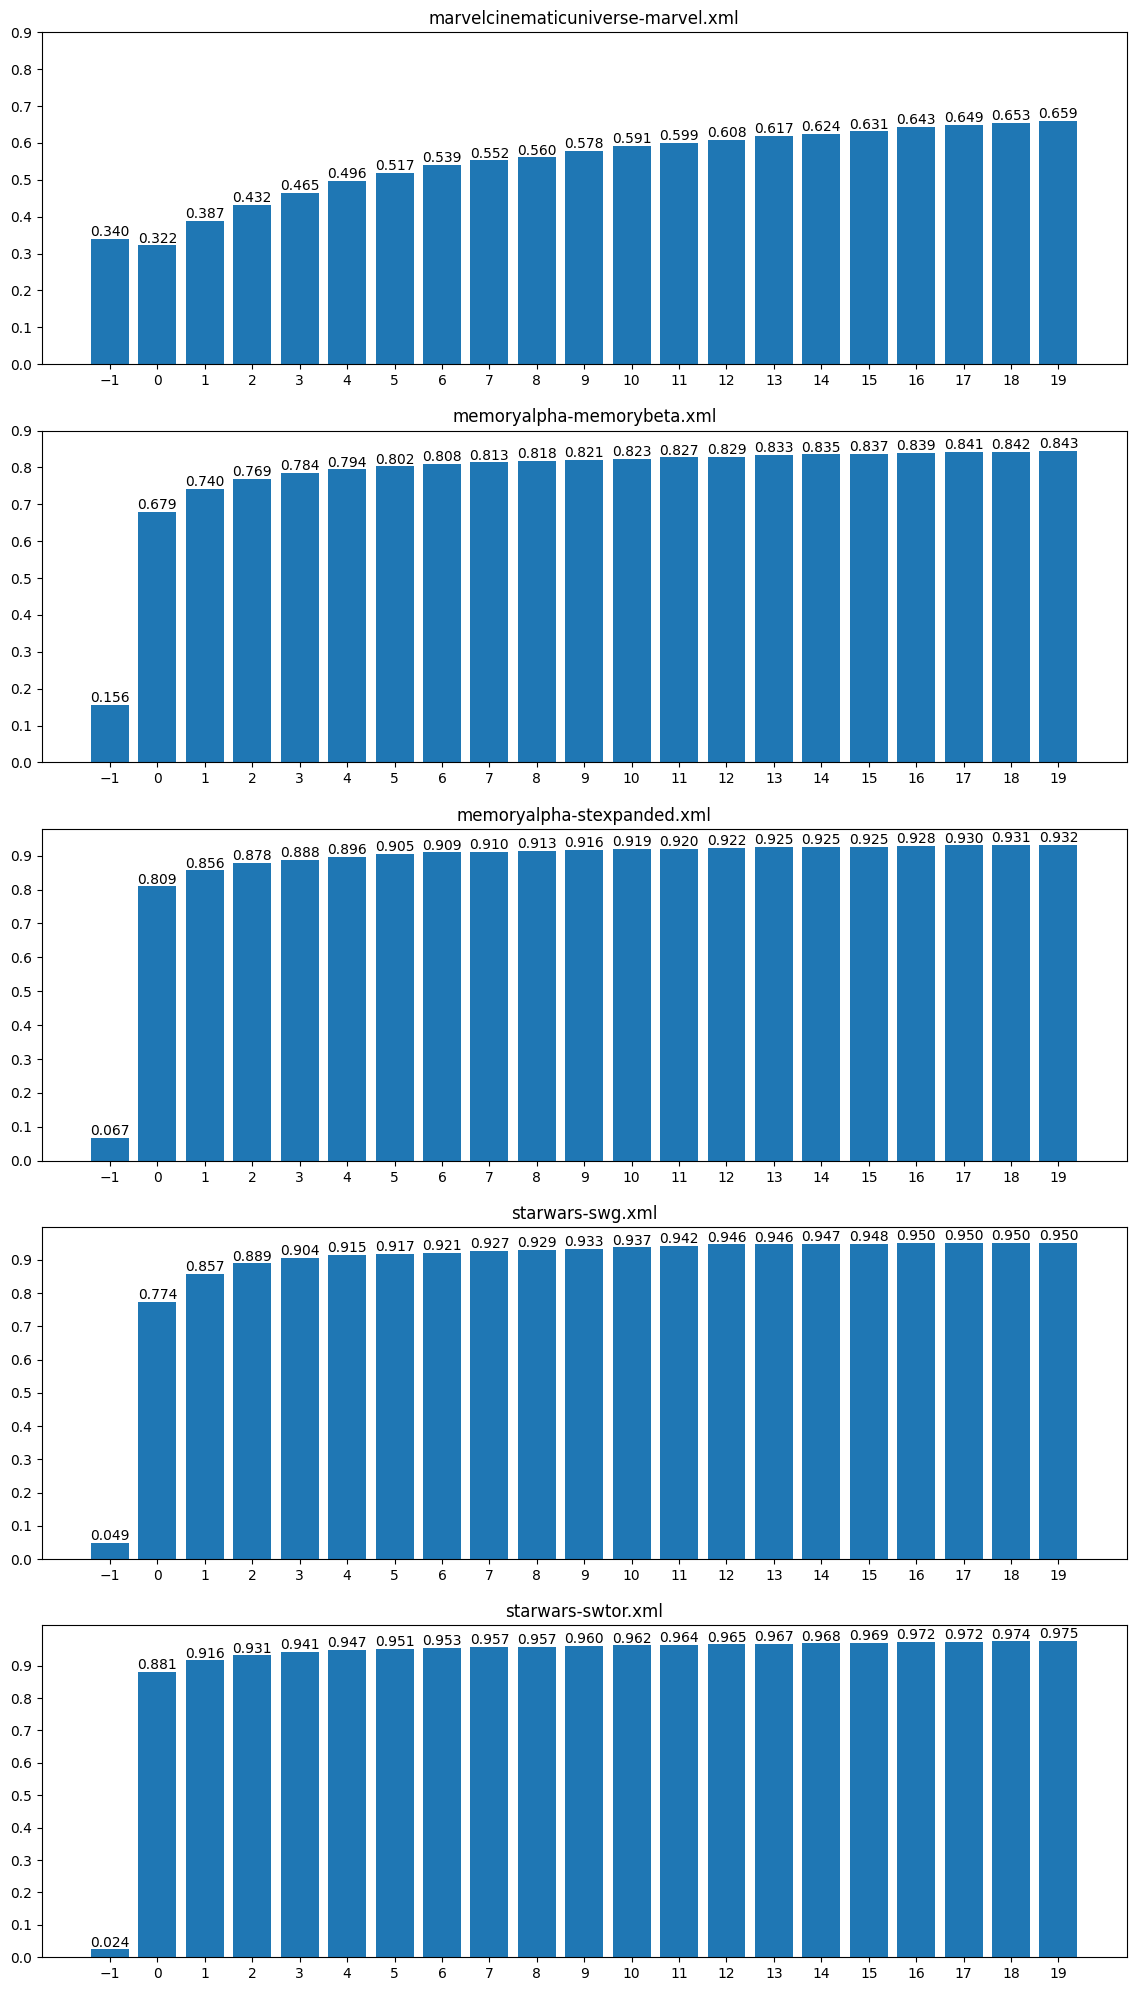

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(found_golds_on_position), figsize=(14, len(found_golds_on_position) * 5))

for i, k_v in enumerate(found_golds_on_position.items()):
    accumulate_list = create_accumulate(Counter(k_v[1]))
    accumulate_list_percent = np.array(accumulate_list)/(accumulate_list[0]+accumulate_list[-1])
    axes[i].bar([i for i in range(-1, 20)], accumulate_list_percent)
    axes[i].set_title(k_v[0])
    axes[i].set_xticks([i for i in range(-1, 20)])
    axes[i].set_yticks([i/10 for i in range(0, 10)])


    rects = axes[i].patches
    
    for j, value in enumerate(accumulate_list_percent):
        axes[i].annotate(str(value)[:5], (j-1, value),            
                         xytext=(0, 10),          # Vertically shift label by `space`
                         textcoords="offset points", # Interpret `xytext` as offset in points
                         ha='center',                # Horizontally center label
                         va="top")
